In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [3]:
def nc_underest(new_lb, new_ub, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-8):
    """
    Parameters:
        delta (float): range of variable
        n_samples (float): number of sample nodes
        v_list (list): list of scenario functions  
        model: model with submodels corresponds to each scenario
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    N=1 ###############################################################################################
    y_nodes = np.linspace(new_lb, new_ub, n_samples).tolist()
    lst = np.ones(N).tolist() 
    y_opt_list = np.ones(N).tolist() 
    as_nodes_list = np.ones(N).tolist() 
    ms_list = np.ones(N).tolist() 
    
    current_new_nodes = []
    new_nodes_list = []
    
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = tolerance
    solver.options['NonConvex'] = 2 
        
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    for k in range(add_node_num+1):
        for i in range(N):
            as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
        
            # define piecewise function for each scenario
            if hasattr(model_list[i], 'As'):
                model_list[i].del_component('As')
            if hasattr(model_list[i], 'pw'):
                model_list[i].del_component('pw')
            if hasattr(model_list[i], 'obj'):
                model_list[i].del_component('obj')

            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            ms_list[i] = results.problem.lower_bound
            
            new_node = value(model_list[i].y)
            if new_node not in y_nodes:
                bisect.insort(y_nodes, new_node)
            #y_opt_list[i] = value(model_list[i].y)
            

    
    
    # define and solve the sum model
    #print(22)
    #assum_nodes = np.sum(as_nodes_list, axis=0).tolist()
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=assum_nodes,
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    solver.solve(model_sum)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("bad bad bad")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    #errors = value(model_sum.obj) + sum(ms_list)
    errors = -errors
    
    errors = -ms_list[0]
    delta = (new_ub-new_lb)/2
    
    print('node is ',add_node_num)
    print('error is ',errors)
    print('')
    print(' ')
    
    #return delta, errors, 1, 2  # diameter, error
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], y_opt_list[0]

In [4]:
# make delta list
##deltas = np.array([1, 1e-1, 1e-2,1e-03, 1e-4, 1e-5])
adds = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
adds = np.arange(0, 23)
#adds = np.array([11,12,13,14,15,16])
#adds = np.array([15,16,17,18])
results = [compute_piecewise_hausdorff(-1,1,v_list,model_list,a) for a in adds]

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


node is  0
error is  0.1767907867025013

 
node is  1
error is  0.17677773815248723

 
node is  2
error is  0.0884307343096409

 
node is  3
error is  0.0884189120642996

 
node is  4
error is  0.044428064471137584

 
node is  5
error is  0.044222960481041074

 
node is  6
error is  0.029442873169959416

 
node is  7
error is  0.029430254517859772

 
node is  8
error is  0.022268726130897292

 
node is  9
error is  0.022118110570560564

 
node is  10
error is  0.014732943144615929

 
node is  11
error is  0.014566641631830468

 
node is  12
error is  0.012563133210831079

 
node is  13
error is  0.012563385583746922

 
node is  14
error is  0.011136192861275982

 
node is  15
error is  0.011124840763466846

 
node is  16
error is  0.00882813728543691

 
node is  17
error is  0.008795319398508361

 
node is  18
error is  0.0073663411476903515

 
node is  19
error is  0.007363876878229633

 
node is  20
error is  0.006340096060923561

 
node is  21
error is  0.0063069058376740705

 
node

In [ ]:
compute_piecewise_hausdorff(-1,1,v_list,model_list,24)

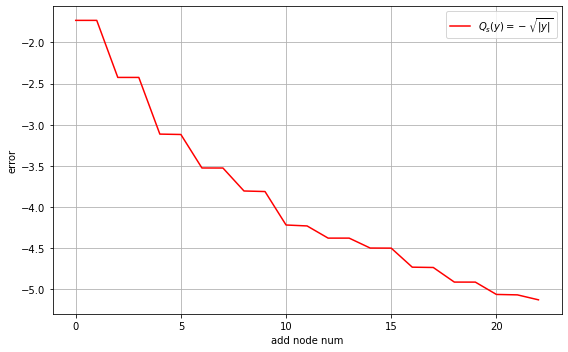

In [5]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(adds, np.log(errors), label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')

plt.xlabel('add node num')
plt.ylabel('error')
#plt.title(f"Plot for {0:.1f} add nodes")
plt.legend()
plt.grid(True)
#plt.xlim(-0.2, 0.2)  
#plt.ylim(-0.5, 0)  

plt.tight_layout()

In [ ]:
nc_underest